# Test Driven Development

**Project Goals**: 
- Take the code for accessing the API and build an AlphaVantageAPI class.
- Create a SQLRepository class that will help us load our stock into a SQLite database, then extract then extract it for later use.

In [1]:
%load_ext autoreload
%load_ext sql
%autoreload 2

import sqlite3

import matplotlib.pyplot as plt
import pandas as pd
from config import settings

d:\workspace\applied-data_science\venv\Lib\site-packages\pydantic\_internal\_fields.py:160: UserWarning: Field "model_directory" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ('settings_',)`.
  warnings.warn(


### AlphaVantageAPI Class

- Importing the ```AlphaVantageAPI``` class from the data module and create an instance of it 

In [2]:
# Import `AlphaVantageAPI`
from data import AlphaVantageAPI

# Create instance of `AlphaVantageAPI` class
av = AlphaVantageAPI()

print("av type:", type(av))

av type: <class 'data.AlphaVantageAPI'>


### AlphaVantageAPI: Get_daily Method

- Using the ```get_daily``` method to fetch the  stock data for the renewable energy company Suzlon and assign it to the DataFrame df_suzlon.

In [3]:
# Define Suzlon ticker symbol
ticker = "SUZLON.BSE"

# Use your `av` object to get daily data
df_suzlon = av.get_daily(ticker)

print("df_suzlon type:", type(df_suzlon))
print("df_suzlon shape:", df_suzlon.shape)
df_suzlon.head()

df_suzlon type: <class 'pandas.core.frame.DataFrame'>
df_suzlon shape: (4589, 5)


,open,high,low,close,volume
date,,,,,
2024-06-05,45.13,49.20,45.13,48.35,14381150.0
2024-06-04,52.19,52.19,47.50,47.50,8835466.0
2024-06-03,49.99,49.99,49.99,49.99,2611005.0
2024-05-31,45.40,47.62,44.21,47.61,4181822.0
2024-05-30,46.40,46.90,44.70,45.36,6019019.0


### AlphaVantageAPI: Testing Get_daily Method

- assert statements to test the output of your ```get_daily``` method

In [4]:
# Does `get_daily` return a DataFrame?
assert isinstance(df_suzlon, pd.DataFrame)

# Does DataFrame have 5 columns?
assert df_suzlon.shape[1] == 5

# Does DataFrame have a DatetimeIndex?
assert isinstance(df_suzlon.index , pd.DatetimeIndex)

# Is the index name "date"?
assert df_suzlon.index.name  == "date"

More Tests:

In [5]:
# Does DataFrame have correct column names?
assert all(df_suzlon.columns == ['open', 'high', 'low', 'close', 'volume'])
assert df_suzlon.columns.to_list() == ['open', 'high', 'low', 'close', 'volume']
# Are columns correct data type?
assert all(df_suzlon.dtypes == float)

### SQL Repository Class

- For storing data into the database. Because our data is highly structured (each DataFrame we extract from AlphaVantage is always going to have the same five columns), it makes sense to use a SQL database.

#### Connect to Database

In [6]:
connection = sqlite3.connect(database=settings.db_name, check_same_thread=False)

print("connection type:", type(connection))

connection type: <class 'sqlite3.Connection'>


#### SQLRepository: Tests

In [7]:
# Import class definition
from data import SQLRepository

# Create instance of class
repo = SQLRepository(connection=connection)

# Does `repo` have a "connection" attribute?
hasattr (repo, "connection") 

# # Is the "connection" attribute a SQLite `Connection`?
assert isinstance(repo.connection, sqlite3.Connection)

#### SQLRepository: Tests for Insert_table Method

In [8]:
response = repo.insert_table(table_name=ticker, records=df_suzlon, if_exists="replace")

# Does your method return a dictionary?
assert isinstance(response, dict)

# Are the keys of that dictionary correct?
assert sorted(list(response.keys())) == ["records_inserted", "transaction_successful"]

In [9]:
response

{'transaction_successful': True, 'records_inserted': 4589}

In [11]:
%load_ext sql
%sql sqlite:///D:\workspace\applied-data_science\0x07-market_forecasting_in_india\stocks.sqlite

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [12]:
%%sql

SELECT *
FROM "SUZLON.BSE"
LIMIT 5

 * sqlite:///D:\workspace\applied-data_science\0x07-market_forecasting_in_india\stocks.sqlite
Done.


date,open,high,low,close,volume
2024-06-05 00:00:00,45.13,49.2,45.13,48.35,14381150.0
2024-06-04 00:00:00,52.19,52.19,47.5,47.5,8835466.0
2024-06-03 00:00:00,49.99,49.99,49.99,49.99,2611005.0
2024-05-31 00:00:00,45.4,47.62,44.21,47.61,4181822.0
2024-05-30 00:00:00,46.4,46.9,44.7,45.36,6019019.0


#### Read SQL Data with Pandas

In [13]:
sql = 'SELECT * FROM "SUZLON.BSE"'
df_suzlon_test = pd.read_sql(
    sql=sql, con = connection,
    parse_dates=["date"],
    index_col="date"
)

print("df_suzlon_test type:", type(df_suzlon_test))
print()
print(df_suzlon_test.info())
df_suzlon_test.head()

df_suzlon_test type: <class 'pandas.core.frame.DataFrame'>

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4589 entries, 2024-06-05 to 2005-10-20
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    4589 non-null   float64
 1   high    4589 non-null   float64
 2   low     4589 non-null   float64
 3   close   4589 non-null   float64
 4   volume  4589 non-null   float64
dtypes: float64(5)
memory usage: 215.1 KB
None


,open,high,low,close,volume
date,,,,,
2024-06-05,45.13,49.20,45.13,48.35,14381150.0
2024-06-04,52.19,52.19,47.50,47.50,8835466.0
2024-06-03,49.99,49.99,49.99,49.99,2611005.0
2024-05-31,45.40,47.62,44.21,47.61,4181822.0
2024-05-30,46.40,46.90,44.70,45.36,6019019.0


#### Read_table Function Tests

In [14]:
# Assign `read_table` output to `df_suzlon`
df_suzlon = repo.read_table(table_name="SUZLON.BSE", limit=2500)  # noQA F821

# Is `df_suzlon` a DataFrame?
assert isinstance(df_suzlon, pd.DataFrame)

# Does it have a `DatetimeIndex`?

assert isinstance(df_suzlon.index, pd.DatetimeIndex)
# Is the index named "date"?

assert df_suzlon.index.name == "date"
# Does it have 2,500 rows and 5 columns?

df_suzlon.shape == (2500, 5)

# Are the column names correct?

assert df_suzlon.columns.to_list() == ['open', 'high', 'low', 'close', 'volume']
# Are the column data types correct?

assert all(df_suzlon.dtypes == float)
# Print `df_suzlon` info
print("df_suzlon shape:", df_suzlon.shape)
print()
print(df_suzlon.info())
df_suzlon.head()

df_suzlon shape: (2500, 5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2500 entries, 2024-06-05 to 2014-04-11
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2500 non-null   float64
 1   high    2500 non-null   float64
 2   low     2500 non-null   float64
 3   close   2500 non-null   float64
 4   volume  2500 non-null   float64
dtypes: float64(5)
memory usage: 117.2 KB
None


,open,high,low,close,volume
date,,,,,
2024-06-05,45.13,49.20,45.13,48.35,14381150.0
2024-06-04,52.19,52.19,47.50,47.50,8835466.0
2024-06-03,49.99,49.99,49.99,49.99,2611005.0
2024-05-31,45.40,47.62,44.21,47.61,4181822.0
2024-05-30,46.40,46.90,44.70,45.36,6019019.0


#### Read_table Function

In [15]:
table_name = "AAPL"
limit = 50

if limit:
    sql = f"SELECT * FROM '{table_name}' LIMIT {limit}"
else:
    sql = f"SELECT * FROM '{table_name}'"

print(sql)

SELECT * FROM 'AAPL' LIMIT 50


In [16]:
def read_table(table_name, limit=None):
    
        """Read table from database.

        Parameters
        ----------
        table_name : str
            Name of table in SQLite database.
        limit : int, None, optional
            Number of most recent records to retrieve. If `None`, all
            records are retrieved. By default, `None`.

        Returns
        -------
        pd.DataFrame
            Index is DatetimeIndex "date". Columns are 'open', 'high',
            'low', 'close', and 'volume'. All columns are numeric.
        """
        # Create SQL query (with optional limit)
        if limit:
            sql = f"SELECT * FROM '{table_name}' LIMIT {limit}"
        else:
            sql = f"SELECT * FROM '{table_name}'"

        # Retrieve data, read into DataFrame
        
        df= pd.read_sql(
            sql=sql, con = connection,
            parse_dates=["date"],
            index_col="date"
        )

        # Return DataFrame
        return df

In [17]:
read_table("SUZLON.BSE", 5)

,open,high,low,close,volume
date,,,,,
2024-06-05,45.13,49.20,45.13,48.35,14381150.0
2024-06-04,52.19,52.19,47.50,47.50,8835466.0
2024-06-03,49.99,49.99,49.99,49.99,2611005.0
2024-05-31,45.40,47.62,44.21,47.61,4181822.0
2024-05-30,46.40,46.90,44.70,45.36,6019019.0


### Comparing Stock Returns

In [18]:
ticker = "AMBUJACEM.BSE"

# Get Ambuja data using `av`
ambuja_records = av.get_daily(ticker)

# Insert `ambuja_records` database using `repo`
response = repo.insert_table(
    table_name=ticker,
    records=ambuja_records,
    if_exists="replace"
)

response

{'transaction_successful': True, 'records_inserted': 4785}

In [19]:
ambuja_records.shape

(4785, 5)

Read Ambuja Data From Database

In [20]:
ticker = "AMBUJACEM.BSE"
df_ambuja = repo.read_table(table_name=ticker, limit=2500)

print("df_ambuja type:", type(df_ambuja))
print("df_ambuja shape:", df_ambuja.shape)
df_ambuja.head()

df_ambuja type: <class 'pandas.core.frame.DataFrame'>
df_ambuja shape: (2500, 5)


,open,high,low,close,volume
date,,,,,
2024-06-05,576.75,601.75,550.35,599.05,493444.0
2024-06-04,670.60,670.60,518.00,557.40,1110009.0
2024-06-03,665.05,676.65,653.20,670.60,558604.0
2024-05-31,628.95,639.40,623.45,634.30,84665.0
2024-05-30,625.05,631.15,617.00,618.70,115283.0


#### Plot Ambuja Closing Price

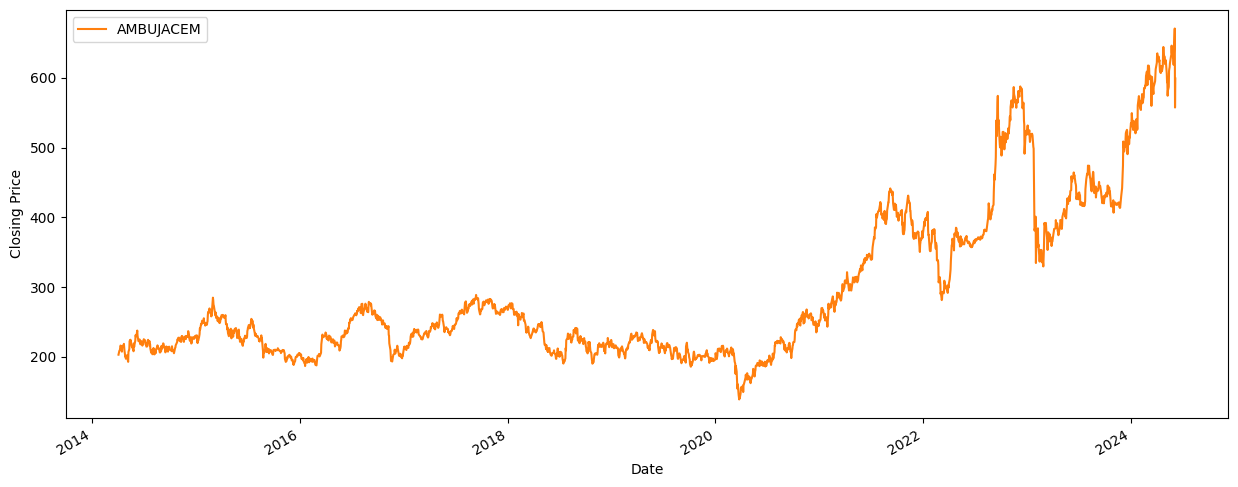

In [21]:
fig, ax = plt.subplots(figsize=(15, 6))
# Plot `df_ambuja` closing price
df_ambuja["close"].plot(ax=ax, label="AMBUJACEM", color="C1")

# Label axes
plt.xlabel("Date")
plt.ylabel("Closing Price")


# Add legend
plt.legend();

#### Comparing Ambuja and Suzlon Closing Price

In [22]:
ticker = "SUZLON.BSE"
df_suzlon = repo.read_table(table_name=ticker, limit=2500)

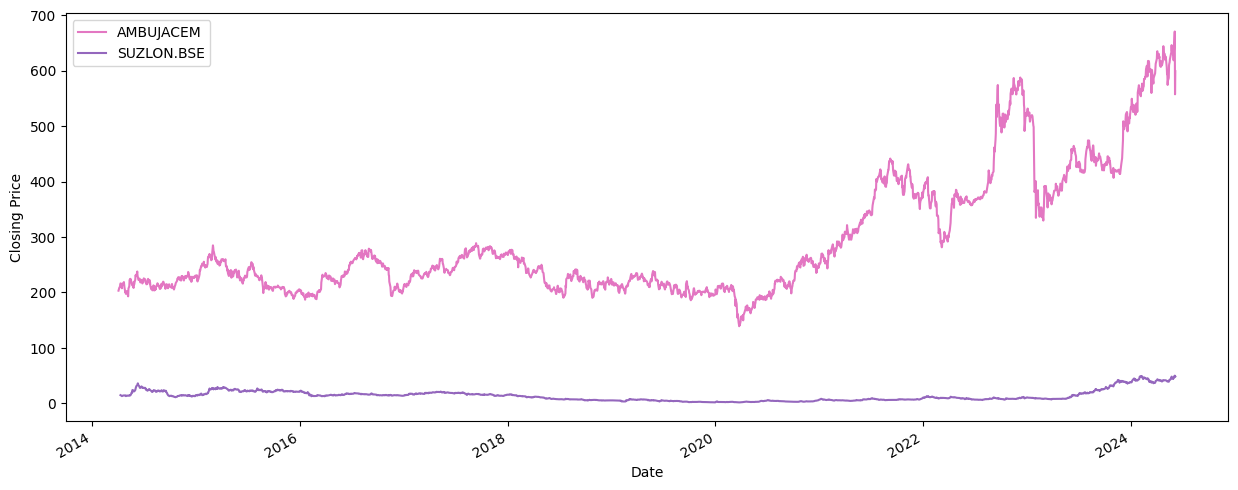

In [23]:
fig, ax = plt.subplots(figsize=(15, 6))
# Plot `df_suzlon` and `df_ambuja`
df_ambuja["close"].plot(ax=ax, label="AMBUJACEM", color="C6")
df_suzlon["close"].plot(ax=ax, label="SUZLON.BSE", color="C4")

# Label axes
plt.xlabel("Date")
plt.ylabel("Closing Price")


# Add legend
plt.legend();

#### Calculating Returns

In [24]:
# Sort DataFrame ascending by date
df_ambuja.sort_index(ascending=True, inplace = True)


# Create "return" column
df_ambuja["return"] = df_ambuja["close"].pct_change()*100

print("df_ambuja shape:", df_ambuja.shape)
print(df_ambuja.info())
df_ambuja.head()

df_ambuja shape: (2500, 6)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2500 entries, 2014-04-04 to 2024-06-05
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2500 non-null   float64
 1   high    2500 non-null   float64
 2   low     2500 non-null   float64
 3   close   2500 non-null   float64
 4   volume  2500 non-null   float64
 5   return  2499 non-null   float64
dtypes: float64(6)
memory usage: 136.7 KB
None


,open,high,low,close,volume,return
date,,,,,,
2014-04-04,204.75,206.00,201.70,203.25,63729.0,NaN
2014-04-07,202.50,209.20,202.05,208.75,203700.0,2.706027
2014-04-09,209.00,211.80,208.00,210.10,111410.0,0.646707
2014-04-10,211.00,215.80,209.00,212.55,228126.0,1.166111
2014-04-11,211.00,216.85,210.55,216.35,366601.0,1.787815


In [25]:
# Sort DataFrame ascending by date
df_suzlon.sort_index(ascending=True, inplace = True)


# Create "return" column
df_suzlon["return"] = df_suzlon["close"].pct_change()*100

print("df_suzlon shape:", df_suzlon.shape)
print(df_suzlon.info())
df_suzlon.head()

df_suzlon shape: (2500, 6)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2500 entries, 2014-04-11 to 2024-06-05
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2500 non-null   float64
 1   high    2500 non-null   float64
 2   low     2500 non-null   float64
 3   close   2500 non-null   float64
 4   volume  2500 non-null   float64
 5   return  2499 non-null   float64
dtypes: float64(6)
memory usage: 136.7 KB
None


,open,high,low,close,volume,return
date,,,,,,
2014-04-11,15.00,15.20,14.64,14.85,4354753.0,NaN
2014-04-15,14.90,15.02,13.26,13.79,3399629.0,-7.138047
2014-04-16,13.71,14.07,13.02,13.11,3265759.0,-4.931109
2014-04-17,13.25,13.55,13.07,13.36,3944451.0,1.906941
2014-04-21,13.50,14.52,13.35,14.26,5489243.0,6.736527


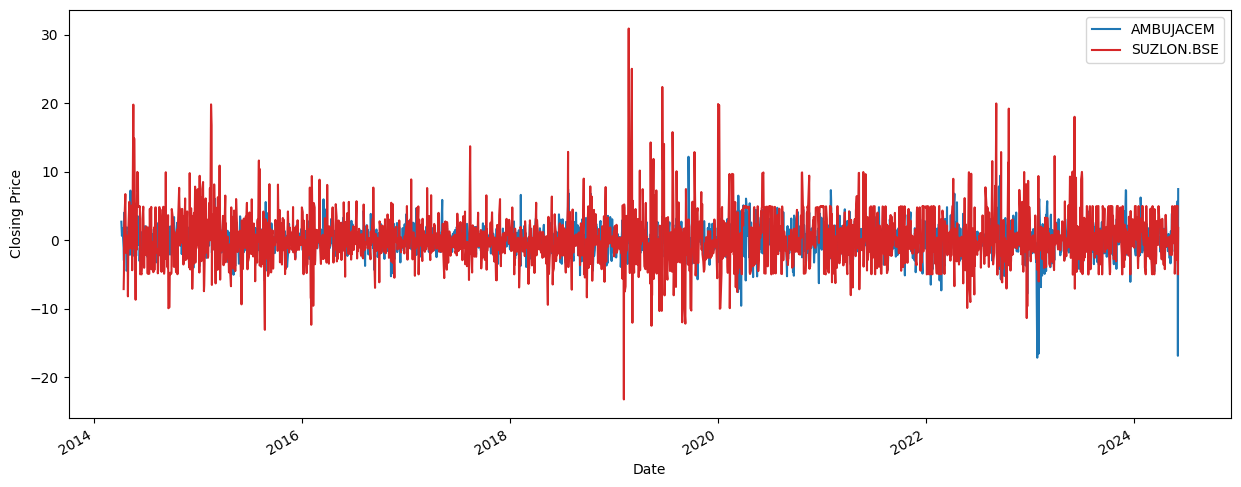

In [26]:
fig, ax = plt.subplots(figsize=(15, 6))
# Plot `df_suzlon` and `df_ambuja`
df_ambuja["return"].plot(ax=ax, label="AMBUJACEM", color="C0")
df_suzlon["return"].plot(ax=ax, label="SUZLON.BSE", color="C3")

# Label axes
plt.xlabel("Date")
plt.ylabel("Closing Price")


# Add legend
plt.legend();

- Overall, we see that the returns for Suzlon have a wider spread. We see big gains and big losses. In contrast, the spread for Ambuja is narrower, meaning that the price doesn't fluctuate as much.